In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from itertools import islice
import time
import matplotlib.pyplot as plt

batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### LeNet

Точность без обучения: 8.80%
SGD:
Эпоха: 1, Потери: 0.035866282507777215
Эпоха: 2, Потери: 0.03525619531671206
Эпоха: 3, Потери: 0.032094359397888184
Эпоха: 4, Потери: 0.018580674876769385
Эпоха: 5, Потери: 0.00942733301781118
Точность SGD: 86.60%
Время обучения: 3.8630001544952393 с

AdaDelta:
Эпоха: 1, Потери: 0.03013832544287046
Эпоха: 2, Потери: 0.00998493586666882
Эпоха: 3, Потери: 0.005018179429074129
Эпоха: 4, Потери: 0.003994669004653891
Эпоха: 5, Потери: 0.0032110347451331715
Точность AdaDelta: 89.80%
Время обучения: 3.864000082015991 с

NAG:
Эпоха: 1, Потери: 0.035397634468972684
Эпоха: 2, Потери: 0.025618412438780068
Эпоха: 3, Потери: 0.0122632779336224
Эпоха: 4, Потери: 0.005509130043598513
Эпоха: 5, Потери: 0.004923136730212718
Точность NAG: 89.50%
Время обучения: 3.8340003490448 с

Adam:
Эпоха: 1, Потери: 0.02077223057858646
Эпоха: 2, Потери: 0.006349561068539818
Эпоха: 3, Потери: 0.004243372745501499
Эпоха: 4, Потери: 0.0032929808793899914
Эпоха: 5, Потери: 0.00292352929

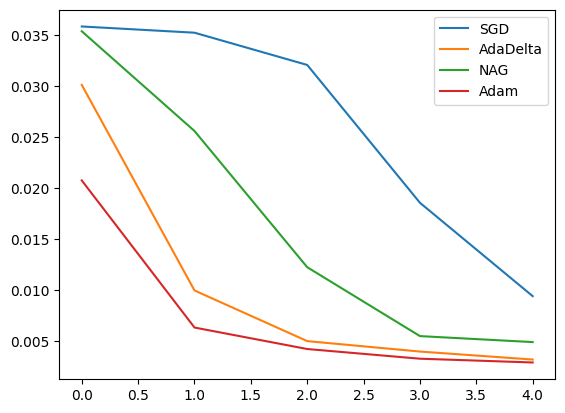

In [54]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 256)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net0 = LeNet()
net = LeNet()
criterion = nn.CrossEntropyLoss()

def resetNet():
    net.load_state_dict(net0.state_dict())

def countAccuracy():
    correct = 0
    size = 1000
    for image, label in islice(testset, size):
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        correct += predicted == label
    return 100 * correct.item() / size#len(testset)

def train(optimizer, optim_name):
    print(f"{optim_name}:")
    start_time = time.time()
    xs, ys = [], []
    batch_num = 30
    for epoch in range(5):
        running_loss = 0.0
        for inputs, labels in islice(trainloader, batch_num):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        xs.append(epoch + 1)
        ys.append(running_loss / (batch_num * batch_size))
        print(f'Эпоха: {xs[-1]}, Потери: {ys[-1]}')
    plt.plot(xs, ys, label = optim_name)
    print(f"Точность {optim_name}: {countAccuracy():.2f}%")
    print(f"Время обучения: {time.time() - start_time} с\n")

resetNet()
print(f"Точность без обучения: {countAccuracy():.2f}%")
SGD = optim.SGD(net.parameters(), lr=0.1)
train(SGD, "SGD")
resetNet()
AdaDelta = optim.Adadelta(net.parameters(), lr=1.0)
train(AdaDelta, "AdaDelta")
resetNet()
NAG = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, nesterov=True)
train(NAG, "NAG")
resetNet()
Adam = optim.Adam(net.parameters(), lr=0.005)
train(Adam, "Adam")

plt.legend()
plt.show()

In [55]:
print(torch.cuda.is_available())

False
